# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Вы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузите данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. Если работаете локально, скачать файл можно по ссылке.

Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Москвы проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическую записку, в которой опишите:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

## Сравнение времени активности пользователей из Москвы и Санкт-Петербурга  в приложении Яндекс Книги

- Автор: Александра Попова
- Дата: 17.04.2025

## Цели и задачи проекта

Цель проекта - провести сравнение времени, которе проводят в приложении пользователи из Санкт-Петербурга и из Москвы.

## Описание данных

Датасет yandex_knigi_data содержит поля:

* city - город, Москва или Санкт-Петербург
* puid - id пользователя
* hours - количество часов, проведенное в приложении за 3 месяца

## Содержимое проекта

1. Загрузка данных и знакомство с ними
2. Проверка гипотезы
3. Аналитическая записка
---

## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
# импорт библиотек, загрузка данных
from matplotlib import pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
import pandas as pd
from scipy import stats as st
from scipy.stats import ttest_ind
import numpy as np


In [2]:
df=pd.read_csv('/datasets/yandex_knigi_data.csv')
df.head(10)

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434
5,5,Москва,352567,8.206369
6,6,Москва,439493,0.857758
7,7,Москва,494541,0.035072
8,8,Москва,647235,12.000076
9,9,Москва,656480,0.973032


In [3]:
#проверим наличие дубликатов
df.duplicated('puid').sum()

244

In [4]:
#удалим дубликаты
df = df.drop_duplicates(subset='puid', keep='first')

Посчитаем количество пользователей по городам

In [5]:
grouped=df.groupby('city').agg ({
    'hours':'sum',
    'puid':'count'
}).reset_index()
grouped.columns=['city','hours','puid']
grouped

,city,hours,puid
0,Москва,67832.727924,6234
1,Санкт-Петербург,25975.783344,2306


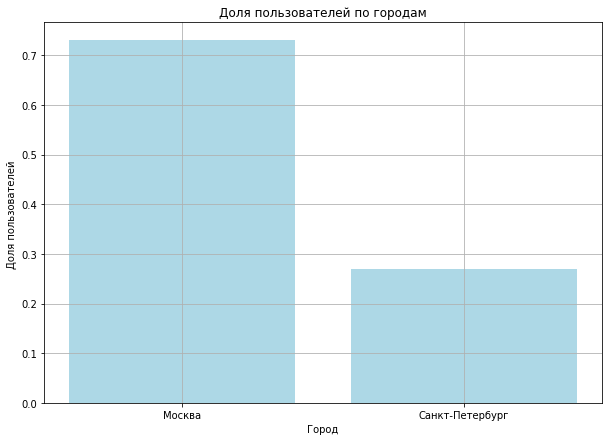

In [6]:
x = grouped['city']
y = grouped['puid']/grouped['puid'].sum()

plt.figure(figsize=(10, 7))

plt.bar(x, y,label ='', color='lightblue')

plt.xlabel("Город")
plt.ylabel("Доля пользователей ")

plt.title('Доля пользователей по городам')

plt.grid()
plt.show()

Пользователей из Москвы в три раза больше.

In [7]:
grouped['avg_hours']=round(grouped['hours']/grouped['puid'],2)

grouped

,city,hours,puid,avg_hours
0,Москва,67832.727924,6234,10.88
1,Санкт-Петербург,25975.783344,2306,11.26


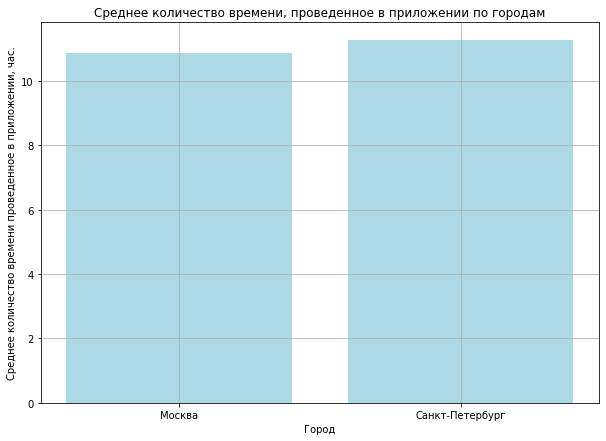

In [8]:
x = grouped['city']
y = grouped['avg_hours']

plt.figure(figsize=(10, 7))

plt.bar(x, y,label ='', color='lightblue')

plt.xlabel("Город")
plt.ylabel("Среднее количество времени проведенное в приложении, час.")

plt.title('Среднее количество времени, проведенное в приложении по городам')

plt.grid()
plt.show()

Пользователи из Санкт-Петербурга проводят в приложении в среднем больше времени.

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

**Выбор теста**: так как нужно сравнить средние значения двух независимых выборок, используем простой тест Стьюдента, он соответствует нашей задаче и позволит определить статистическую значимость наблюдаемых различий.

In [9]:
#t-тест
a=df[df['city']=='Москва']
b=df[df['city']=='Санкт-Петербург']
alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве выборочных средних
stat_ttest, p_value_ttest = ttest_ind(
    a['hours'], 
    b['hours'], 
    alternative='less'
) 

if p_value_ttest>alpha:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
else:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B больше')

p-value теста Стьюдента =0.34
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны


**Вывод**: Нулевая гипотеза находит подтверждение, то есть можем считать, что средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается

## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.




# 📊 Анализ времени активности пользователей из Москвы и Санкт-Петербурга в приложении Яндекс Книги

### Цель
Проверить, есть ли значимое отличие между средним временем активности в москве и Санкт-Петербурге.

---

### Данные
- **Группы**: A (Москва) и B (Санкт-Петербург) 
- **Период**: сентябрь-ноябрь 2024 года
- **Метрика**: среднее количество часов проведенное в приложении

---

### Методы
- Был проведен расчет среднего количества часов по городам
- Была проведена оценка статистической значимости различий между группами проводилась с помощью простого теста Стьюдента

---

### Результаты

Среднее количество часов, проведенных в приложении:
* в Москве 10,88
* в Санкт-Петербурге 11,26

---

###  Статистический тест


В результате проведенного z-теста pvalue=0.34>0,05, то есть нельзя считать результат статистичеси значимым.


### Рекомендации

Наблюдаемую разницу в проведенном в приложении вермени между группами нельзя считать статистически значимой, но в процессе иследования была обнаружена также большая разница между суммарным количеством пользователей по группам. Рекомендую обратить на это внимание.

----

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цели исследования.



**Цель исследования** - провести анализ влияния нового дизайна сайта на количество пользователей, которые совершают покупки.

## 2. Загрузите данные, оцените их целостность.


In [10]:
#загрузим данные
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)


In [11]:
participants.info()
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


Типы данных назначены нормально, пропуски данных наблюдаются в столбце details, но его содержимое не имеет значения для исследования, не будем с ними ничего делать.

In [12]:
participants.head(10)

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac
5,002412F1EB3F6E38,B,interface_eu_test,Mac
6,002540BE89C930FB,B,interface_eu_test,Android
7,0031F1B5E9FBF708,A,interface_eu_test,Android
8,003346BB64227D0C,B,interface_eu_test,Android
9,00341D8401F0F665,A,recommender_system_test,iPhone


В данных есть результаты и другого теста, отфильтруем их

In [13]:
test_prt=participants[participants['ab_test']=='interface_eu_test']
test_prt.head(5)

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
2,001064FEAAB631A1,A,interface_eu_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac
5,002412F1EB3F6E38,B,interface_eu_test,Mac
6,002540BE89C930FB,B,interface_eu_test,Android


In [14]:
events.head(10)

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN
5,AA346F4D22148024,2020-12-01 00:01:46,registration,-2.0
6,7EF01D0E72AF449D,2020-12-01 00:02:06,registration,-5.0
7,9A6276AD14B14252,2020-12-01 00:02:20,registration,-2.0
8,9B186A3B1A995D36,2020-12-01 00:02:37,registration,-3.5
9,9A6276AD14B14252,2020-12-01 00:02:53,login,NaN


In [15]:
#проверим какие есть виды событий
events.groupby('event_name')['user_id'].count()

event_name
End of Black Friday Ads Campaign           1
Start of CIS New Year Gift Lottery         1
Start of Christmas&New Year Promo          1
login                                 248285
product_cart                           94373
product_page                          195606
purchase                              104836
registration                          144183
Name: user_id, dtype: int64

In [16]:
#посчитаем количество полных дубликатов
db=events.duplicated().sum()
share_db=db/events.shape[0]
db, share_db

(36318, 0.04613063105402611)

In [17]:
#удалим дубликаты
events=events.drop_duplicates()
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750968 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     750968 non-null  object        
 1   event_dt    750968 non-null  datetime64[ns]
 2   event_name  750968 non-null  object        
 3   details     244905 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 28.6+ MB


## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [18]:
a=test_prt[test_prt['group']=='A']
b=test_prt[test_prt['group']=='B']
print(a.shape[0], b.shape[0])

5383 5467


Количество пользователей в группах приблизительно равно, можем проводить тест.

Проверим не попали ли пользователи в 2 группы одновременно

In [19]:
# подсчёт уникальных групп на каждого пользователя
test_prt.groupby('user_id', as_index = False)['group'].nunique().sort_values(by = 'group', ascending = False)

,user_id,group
0,0002CE61FF2C4011,1
7236,AAE1914BDB419328,1
7228,AAB36612EA4F9C17,1
7229,AAB547465C7ED9BF,1
7230,AAB73E7D667084B6,1
...,...,...
3618,55B8C7583E9B3964,1
3619,55C5DC76F3FA1B1B,1
3620,55CF42F4153517E2,1
3621,55D00299E01B6855,1


Пользователей, вошедших в обе группы, не обнаружено.

3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

Для этого проведем объединение данных по user_id

In [20]:
filtred_events=events.merge(test_prt, on='user_id', how='inner')
filtred_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73545 entries, 0 to 73544
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     73545 non-null  object        
 1   event_dt    73545 non-null  datetime64[ns]
 2   event_name  73545 non-null  object        
 3   details     20441 non-null  object        
 4   group       73545 non-null  object        
 5   ab_test     73545 non-null  object        
 6   device      73545 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 4.5+ MB


- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [21]:
#создадим отдельный массив с датами регистрации
filtred_events['event_dt'] = pd.to_datetime(filtred_events['event_dt'])
registrations = filtred_events[filtred_events['event_name'] == 'registration'][['user_id', 'event_dt']]
registrations = registrations.rename(columns={'event_dt': 'registration_time'})

# Джойним события с датой регистрации
df_merged = filtred_events.merge(registrations, on='user_id', how='inner')

# Вычисляем лайфтайм
df_merged['lifetime_days'] = (df_merged['event_dt'] - df_merged['registration_time']).dt.days

# Фильтруем события в первые 7 дней
df_7days = df_merged[df_merged['lifetime_days'] <= 7]
df_7days

,user_id,event_dt,event_name,details,group,ab_test,device,registration_time,lifetime_days
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,A,interface_eu_test,iPhone,2020-12-06 14:10:01,0
1,5F506CEBEDC05D30,2020-12-07 01:25:14,login,NaN,A,interface_eu_test,iPhone,2020-12-06 14:10:01,0
2,5F506CEBEDC05D30,2020-12-07 01:25:47,login,NaN,A,interface_eu_test,iPhone,2020-12-06 14:10:01,0
3,5F506CEBEDC05D30,2020-12-09 12:40:49,login,NaN,A,interface_eu_test,iPhone,2020-12-06 14:10:01,2
4,5F506CEBEDC05D30,2020-12-09 12:40:49,product_page,NaN,A,interface_eu_test,iPhone,2020-12-06 14:10:01,2
...,...,...,...,...,...,...,...,...,...
73540,16CCB1C8C4DCF1AF,2020-12-23 23:50:29,registration,0.0,A,interface_eu_test,Mac,2020-12-23 23:50:29,0
73541,16CCB1C8C4DCF1AF,2020-12-23 23:55:52,login,NaN,A,interface_eu_test,Mac,2020-12-23 23:50:29,0
73542,2DDC948BD76ABC57,2020-12-24 21:57:10,registration,-4.29,B,interface_eu_test,iPhone,2020-12-24 21:57:10,0
73543,2DDC948BD76ABC57,2020-12-24 21:58:49,login,NaN,B,interface_eu_test,iPhone,2020-12-24 21:57:10,0


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [22]:
a=df_7days[df_7days['group']=='A']
b=df_7days[df_7days['group']=='B']
a.shape[0],b.shape[0]

(32031, 33391)

Воспользуемся калькулятором Эвана Миллера, получили, что этой выборки достаточно для проведения теста с минимальным значимым эффектов 2%, но не достаточно для теста с чувствительностью 1%. Учтем это в дальнейших выводах.
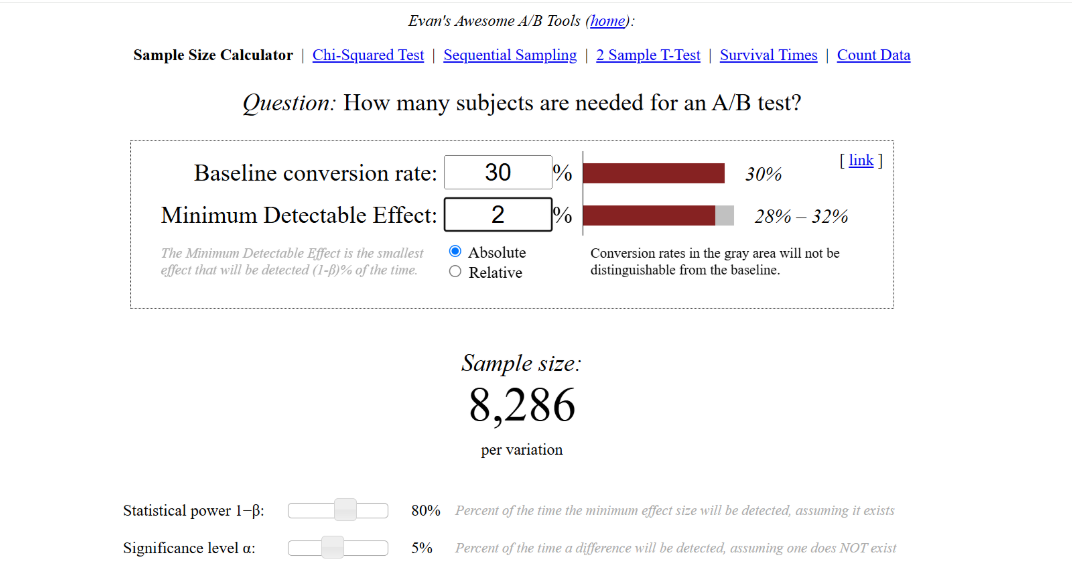
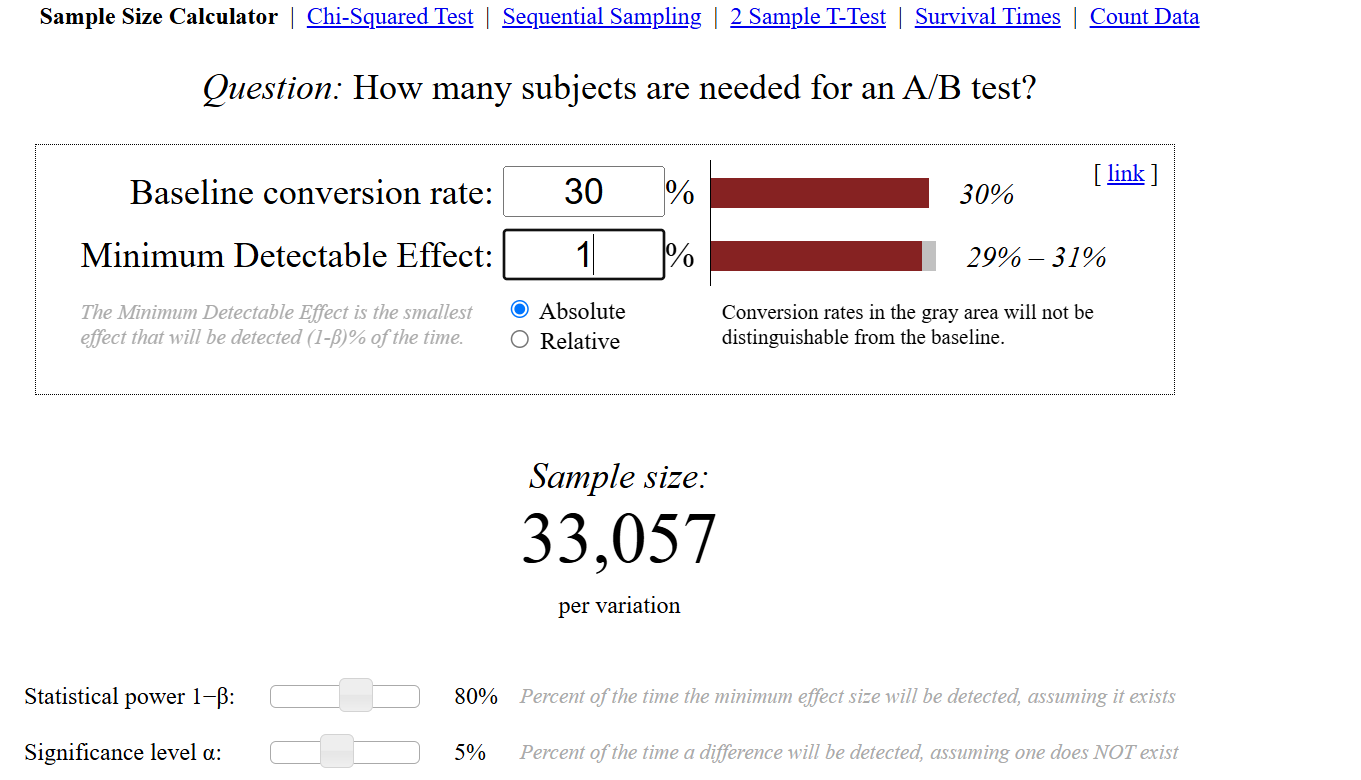

- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [23]:
#посчитаем количество покупателей по группам
byers=df_7days[df_7days['event_name']=='purchase'].groupby('group')['user_id'].nunique().reset_index()
byers.columns=['group','byers']
byers

,group,byers
0,A,1542
1,B,1687


In [24]:
#посчитаем общее количество пользователей по группам
users=df_7days.groupby('group')['user_id'].nunique().reset_index()
users.columns=['group','users']
users

,group,users
0,A,5383
1,B,5467


In [25]:
cr=users.merge(byers, on='group')
cr['cr']=round(100*cr['byers']/cr['users'],2)
cr

,group,users,byers,cr
0,A,5383,1542,28.65
1,B,5467,1687,30.86


- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

По расчетам можем наблюдать рост кнверсии в в тестовой группе на 2,2% по сравнению с контрольной.

## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Так как выбранная метрика долевая, выберем z-тест
Формируем нулевую и альтернативную гипотезу:

Н0: Доля пользователей, которые совершают покупки, в группах А и B не отличаются

Н1: Доля пользователей, которые совершают покупки в группе А меньше чем в группе В 

In [26]:
#z-тест
#проверяем стат значимость гиоптезы: доля успехов в тестовой выборке больше доли успехов в исходной выборке
alpha = 0.05
n_a=users[users['group']=='A']['users']
n_b=users[users['group']=='B']['users']
m_a=byers[byers['group']=='A']['byers']
m_b=byers[byers['group']=='B']['byers']
stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller' # так как H_1: p_a < p_b
)
p_value_ztest


if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=[0.00587033] < 0.05
Нулевая гипотеза не находит подтверждения!


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

## Выводы
Тест был проведен в соответствии с требованиями. Нулевая гипотеза не нашла подтвержения. Можем сделать вывод, что новый дизайн сайта приводит к увеличению доли пользователей, которые совершают покупки на 2,2%. 

## Рекомендации
В тестовой группе конверсия увеличилась на 2,2%, что выше чувствительности теста. А также тест Стьюдента показал, что изменение статистически значимо, поэтому можно рекомендовать внедрение нового дизайна.